In [ ]:
#| default_exp tfsm/flip

In [1]:
%load_ext autoreload
%autoreload 2

In [43]:
#| export 
import numpy as np
import fastcore.all as fc
from typing import List
from voxdet.tfsm.standard import BaseT

In [44]:
from voxdet.utils import vis

In [45]:
def fill_bbox(image, bbox):
    image = np.copy(image)
    for box in bbox:
        z1, y1, x1, z2, y2, x2 = box 
        image[z1:z2, y1:y2, x1:x2] = 1 
    return image

In [52]:
image = np.zeros((25, 196, 196))
bbox = np.asarray([[10, 150, 120, 20, 190, 190], [1, 10, 10, 5, 50, 50]])
imgb = fill_bbox(image, bbox)

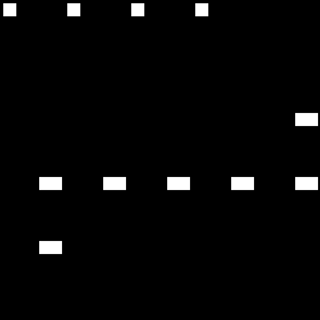

In [53]:
vis(imgb*255, size=64, window=False)

> get flipped image

In [54]:
flip_axis = 1
flipped_image = np.flip(imgb, axis=flip_axis)
flipped_image.shape

(25, 196, 196)

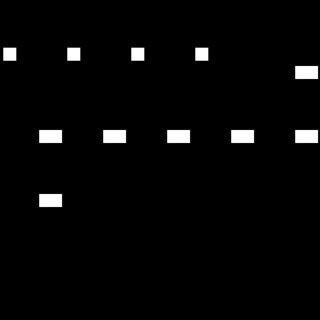

In [55]:
vis(flipped_image*255, size=64, window=False)

> need to adjust bboxes too during flip tfsm

> a flip about axis=0 only affects axes 0 and 3; similarly for axes 1 and 2

In [11]:
axis_flip_indices = [[0, 3], [1, 4], [2, 5]]
axis_flip_indices[flip_axis], axis_flip_indices[flip_axis][::-1]

([2, 5], [5, 2])

> flipping about axis/dim=2; need to subtract x_min, x_max from img shape along the same dim to get new extremes

> sanity check: old x_min + new x_max == old x_max + new x_min == img shape along the concerned dim

In [12]:
bbox

array([[ 10, 150, 120,  20, 190, 190],
       [  1,  10,  10,   5,  50,  50]])

In [13]:
(imgb[bbox[0][0]:bbox[0][3], bbox[0][1]:bbox[0][4], bbox[0][2]:bbox[0][5]] == 1).all()

True

In [14]:
fbbox = bbox.copy()
fbbox[:, axis_flip_indices[flip_axis]] = image.shape[flip_axis] - bbox[:, axis_flip_indices[flip_axis][::-1]]
fbbox

array([[ 10, 150,   6,  20, 190,  76],
       [  1,  10, 146,   5,  50, 186]])

## test - everything inside the box should be one and outside box should be all zeros.

In [15]:
(flipped_image[fbbox[0][0]:fbbox[0][3], fbbox[0][1]:fbbox[0][4], fbbox[0][2]:fbbox[0][5]] == 1).all()

True

## implement the func

In [28]:
#| export
import torch
from typing import Union
# def flip3d(img:np.ndarray, boxes:np.ndarray, flip_axis:int):
#     """img zyx/bzyx format, bboxes in zyxzyx format and flip_axis can be one of [0, 1, 2]
#     flip_axis: 0: depth flip, 1: horizontal flip, 2: vertical flip
#     """
#     assert flip_axis in [0, 1, 2], f"flip axis cannot be {flip_axis}. need to be one of [0, 1, 2]"
#     assert img.ndim in [3, 4], f"works only for 3D images. dimensions can be 3 or 4. Incase 4, 1st dim is channels"
#     fa = flip_axis+1 if img.ndim > 3 else flip_axis
#     flipped_img = np.flip(img, axis=fa)
#     ims = img.shape[1:] if img.ndim > 3 else img.shape
#     idx_pairs = [[0, 3], [1, 4], [2, 5]]
#     boxes[:, idx_pairs[flip_axis]] = ims[flip_axis] - boxes[:, idx_pairs[flip_axis][::-1]]
#     return flipped_img, boxes

def flip3d(img: Union[np.ndarray, torch.Tensor], boxes: Union[np.ndarray, torch.Tensor], flip_axis: int):
    """img zyx/bzyx format, bboxes in zyxzyx format and flip_axis can be one of [0, 1, 2]
    flip_axis: 0: depth flip, 1: horizontal flip, 2: vertical flip
    """
    assert flip_axis in [0, 1, 2], f"flip axis cannot be {flip_axis}. need to be one of [0, 1, 2]"
    assert img.ndim in [3, 4], f"works only for 3D images. dimensions can be 3 or 4. Incase 4, 1st dim is channels"
    fa = flip_axis + 1 if img.ndim > 3 else flip_axis
    flipped_img = torch.flip(img, [fa]) if isinstance(img, torch.Tensor) else np.flip(img, axis=fa)
    ims = img.shape[1:] if img.ndim > 3 else img.shape
    idx_pairs = [[0, 3], [1, 4], [2, 5]]
    boxes[:, idx_pairs[flip_axis]] = ims[flip_axis] - boxes[:, idx_pairs[flip_axis][::-1]]
    return flipped_img, boxes

### test - original image

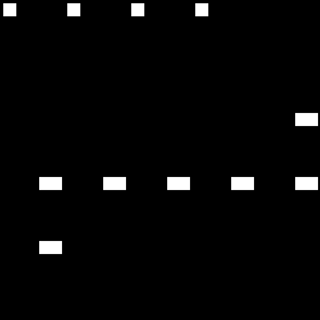

In [29]:
vis(imgb*255, size=64, window=False)

In [31]:
for box in bbox:
    assert (imgb[box[0]:box[3], box[1]:box[4], box[2]:box[5]] == 1).all()

In [32]:
def test_flip(imgb, bbox):
    for box in bbox: assert (imgb[box[0]:box[3], box[1]:box[4], box[2]:box[5]] == 1).all()

In [35]:
bbox

array([[ 10, 150, 120,  20, 190, 190],
       [  1,  10,  10,   5,  50,  50]])

In [39]:
test_flip(torch.tensor(imgb), torch.tensor(bbox))

In [38]:
test_flip(imgb, bbox)

### test vertical flip axis = 1

In [22]:
vimgb, vbbox = flip3d(imgb.copy(), bbox.copy(), flip_axis=1)
vimgb.shape, vbbox

((25, 196, 196),
 array([[ 10,   6, 120,  20,  46, 190],
        [  1, 146,  10,   5, 186,  50]]))

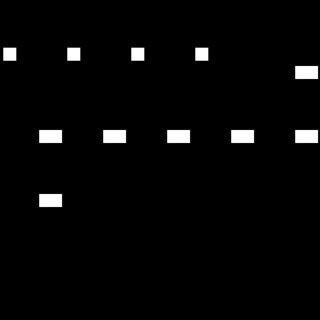

In [ ]:
vis(vimgb*255, size=64, window=False)

In [40]:
vimgb, vbbox = flip3d(torch.tensor(imgb).clone(),torch.tensor(bbox).clone(), flip_axis=1)
vimgb.shape, vbbox

(torch.Size([25, 196, 196]),
 tensor([[ 10,   6, 120,  20,  46, 190],
         [  1, 146,  10,   5, 186,  50]]))

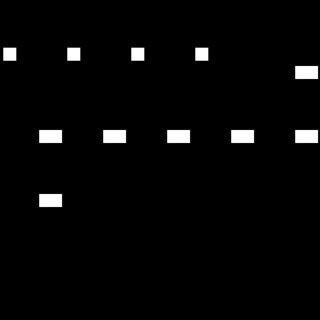

In [42]:
vis(vimgb.numpy()*255, size=64, window=False)

In [ ]:
vimgb, vbbox = flip3d(imgb.copy(), bbox.copy(), flip_axis=1)
vimgb.shape, vbbox

In [23]:
test_flip(vimgb, vbbox)

### test horizontal flip axis = 2

In [24]:
himgb, hbbox = flip3d(imgb.copy(), bbox.copy(), flip_axis=2)
himgb.shape, hbbox

((25, 196, 196),
 array([[ 10, 150,   6,  20, 190,  76],
        [  1,  10, 146,   5,  50, 186]]))

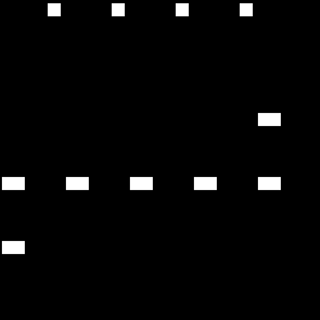

In [25]:
vis(himgb*255, size=64, window=False)

In [26]:
test_flip(himgb, hbbox)

### depth flip axis=0

In [27]:
dimgb, dbbox = flip3d(imgb.copy(), bbox.copy(), flip_axis=0)
dimgb.shape, dbbox

((25, 196, 196),
 array([[  5, 150, 120,  15, 190, 190],
        [ 20,  10,  10,  24,  50,  50]]))

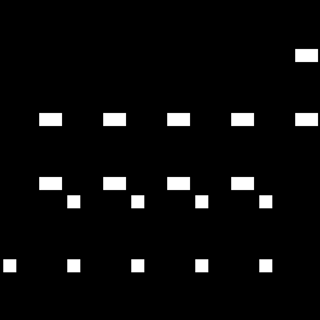

In [ ]:
vis(dimgb*255, size=64, window=False)

In [ ]:
test_flip(dimgb, dbbox)

> get it to work with 4 dimensional image (MIP view)

In [ ]:
def fill_4dbbox(image, bbox):
    image = np.copy(image)
    for box in bbox:
        z1, y1, x1, z2, y2, x2 = box 
        image[:, z1:z2, y1:y2, x1:x2] = 1 
    return image

In [ ]:
image = np.zeros((2, 25, 196, 196))
bbox = np.asarray([[10, 150, 120, 20, 190, 190], [1, 10, 10, 5, 50, 50]])
imgb = fill_4dbbox(image, bbox)

In [ ]:
def test_4dflip(imgb, bbox):
    for box in bbox: assert (imgb[:, box[0]:box[3], box[1]:box[4], box[2]:box[5]] == 1).all()

In [ ]:
test_4dflip(imgb, bbox)

In [ ]:
dimgb, dbbox = flip3d(imgb.copy(), bbox.copy(), flip_axis=0)
vimgb, vbbox = flip3d(imgb.copy(), bbox.copy(), flip_axis=1)
himgb, hbbox = flip3d(imgb.copy(), bbox.copy(), flip_axis=2)

In [ ]:
test_4dflip(dimgb, dbbox)
test_4dflip(vimgb, vbbox)
test_4dflip(himgb, hbbox)

In [ ]:
#| export 
class RandFlip(BaseT):
    def __init__(self, axis:List[int]=None, p:List[float]=None):
        """
        flip the image about given axes with given probabilities
        order of axes will be the order in which the flip transforms
        will be applied
        """
        super().__init__()
        fc.store_attr()
        if len(axis) != len(p): raise ValueError(f"len of axis and p should be same. Got axis={axis} and p={p} ")
    __repr__ = fc.basic_repr(flds="axis, p")
    
    def apply(self, img: dict):
        assert "images" in img.keys()
        fimg = img["images"].copy()
        boxes = img["boxes"].copy()
        
        if isinstance(fimg , np.ndarray) :
            fimg = [fimg]
            boxes = [boxes]
            
        for i in range(len(fimg)) :
            for fa, fp in zip(self.axis, self.p):
                if np.random.random() <= fp:
                    fimg[i] , boxes[i] = flip3d(img=fimg[i], boxes=boxes[i], flip_axis=fa)
        
        if len(fimg) == 1 :
            nimg = {"images":fimg[0], "boxes":boxes[0]}
        else :
            nimg = {"images":fimg, "boxes":boxes}
            
        for i in img.keys(): 
            if i not in ["images", "boxes"]: nimg[i] = img[i]
        return nimg

In [ ]:
vh = RandFlip(axis=[1, 2], p=[1, 1])

In [ ]:
img = {}
img["images"] = imgb
img["boxes"] = bbox

In [ ]:
%%time
pimg = vh(img)

CPU times: user 1.67 ms, sys: 986 µs, total: 2.65 ms
Wall time: 2.72 ms


In [ ]:
test_4dflip(pimg["images"], pimg["boxes"])

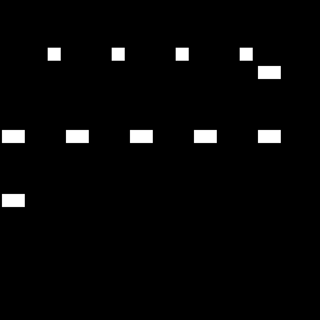

In [ ]:
vis(pimg["images"][0]*255, 64, window=False)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()